In [ ]:
from PIL import Image
import cv2 as cv
import requests
from io import BytesIO
import os
import random
import matplotlib.pyplot as plt
from matplotlib import offsetbox
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

import pickle
import string
import re
import spacy
import nltk
from nltk.stem.snowball import SnowballStemmer

import tensorflow as tf
from tensorflow.keras.applications import vgg16
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.utils import *

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
### LOAD DRESS ###
data = pd.read_csv('FEIDEGGER.csv').fillna(' ')
print(data.shape)
data.head(3)

(43944, 2)


,Image URL,Description
0,https://i2.ztat.net/large/Y0/32/1C/00/UE/11/Y0...,"kurze, sexy, sommer, sexy, party, gelb kleid, ..."
1,https://i2.ztat.net/large/Y0/32/1C/00/UE/11/Y0...,ein gelbes kleid welches eine länge bis etwa ü...
2,https://i2.ztat.net/large/Y0/32/1C/00/UE/11/Y0...,"Knielanges Stoffkleid in gelb mit weitem Rock,..."


In [ ]:
### MERGE DESCRIPTION 4 IMAGE URL ###
newdata = data.groupby('Image URL')['Description'].apply(lambda x: x.str.cat(sep=' ')).reset_index()
print(newdata.shape)
newdata.head(3)

(8792, 2)


,Image URL,Description
0,https://i1.ztat.net/large/0V/B2/1C/00/0A/11/0V...,"Ein weißes, knöchellanges Kleid. Es hat einen ..."
1,https://i1.ztat.net/large/0V/B2/1C/00/4G/11/0V...,Ein rotes faltiges Kleid mit mittellangen Ärme...
2,https://i1.ztat.net/large/1V/J2/1C/02/VH/11/1V...,"Ein Schwarzes etwa Knielanges Kleid, mit einem..."


In [ ]:
### LOAD VGG ###
vgg_model = vgg16.VGG16(weights='imagenet')
feat_extractor = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer("fc2").output)
feat_extractor.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [ ]:
### PREPARE IMAGES FOR VGG ###
## A) READ IMAGES AND EXPAND DIM
importedImages = []

for url in tqdm(newdata['Image URL'][0:2000]):
    
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img = img.resize((224, 224))
    numpy_img = img_to_array(img)
    img_batch = np.expand_dims(numpy_img, axis=0)
    importedImages.append(img_batch.astype('float16'))
    
images = np.vstack(importedImages)

processed_imgs = preprocess_input(images.copy())

100%|██████████| 2000/2000 [03:45<00:00,  8.88it/s]


In [ ]:
### EXTRACT FEATURES ###
## B) MAKE PREDICTION
imgs_features = feat_extractor.predict(processed_imgs)
imgs_features.shape

(2000, 4096)

In [ ]:
### A + B (DONE AND STORED IN A PICKLE) ###
pkl_filename = "img2feat.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(imgs_features, file)

with open("./img2feat.pkl", 'rb') as pickle_file:
    imgs_features = pickle.load(pickle_file)

print(imgs_features.shape)

(2000, 4096)


In [ ]:
### SPLIT TRAIN TEST ###
from sklearn.model_selection import train_test_split

train = imgs_features[:1000]
print(train.shape)

test = imgs_features[1000:]
print(test.shape)

X_train, X_test, y_train, y_test = train_test_split(train, test, test_size=0.8, random_state=0)

(1000, 4096)
(1000, 4096)


In [ ]:
### REDUCE FEATURE DIMENSIONS ###
pca = PCA(n_components=50, random_state=33)
pca_score = pca.fit_transform(imgs_features)

tsne = TSNE(n_components=2, random_state=33, n_iter=300, perplexity=5)
T = tsne.fit_transform(pca_score)

100%|██████████| 200/200 [00:27<00:00,  7.16it/s]


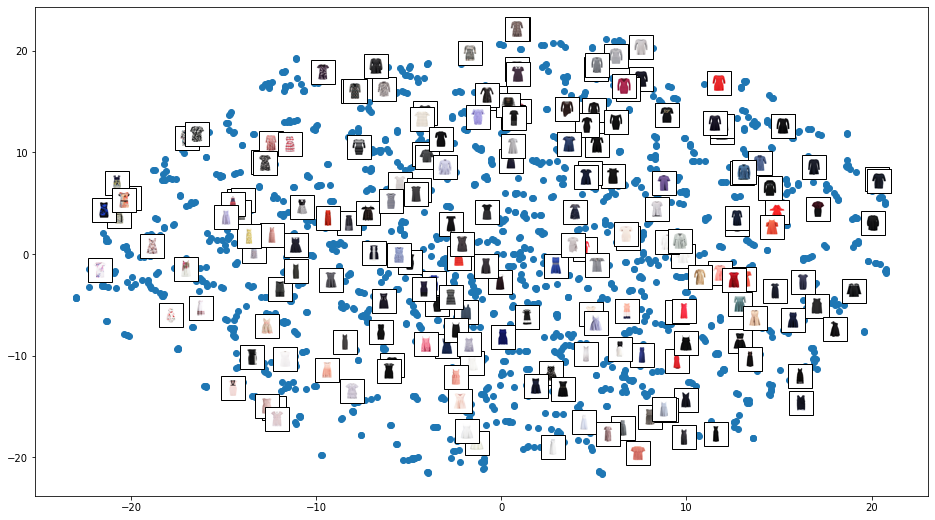

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
ax.scatter(T.T[0], T.T[1]) 
plt.grid(False)

shown_images = np.array([[1., 1.]])
for i in tqdm(np.random.randint(1,T.shape[0],200)):
    
    response = requests.get(newdata['Image URL'][i])
    img = Image.open(BytesIO(response.content))
    img = img.resize((16, 16))
    
    shown_images = np.r_[shown_images, [T[i]]]
    imagebox = offsetbox.AnnotationBbox(offsetbox.OffsetImage(img, cmap=plt.cm.gray_r), T[i])
    ax.add_artist(imagebox)

plt.show()

In [ ]:
### PASS THE TEST ID TO GET THE MOST SIMILAR PRODUCTS ###
def most_similar_products(test_id, n_sim = 3):
    
    #open-plot image
    plt.subplot(1, n_sim+1, 1)
    org_response = requests.get(newdata['Image URL'][train.shape[0]+test_id])
    original = Image.open(BytesIO(org_response.content))
    original = original.resize((224, 224))
    plt.imshow(original)
    plt.title('ORIGINAL')
    
    #compute similarity matrix
    cosSimilarities_serie = cosine_similarity(train, test[test_id].reshape(1,-1)).ravel()
    cos_similarities = pd.DataFrame({'sim':cosSimilarities_serie,'id':newdata[:train.shape[0]].index},
                                    index=newdata['Image URL'][:train.shape[0]]).sort_values('sim',ascending=False)[0:n_sim+1]

    #plot n most similar
    for i in range(0,n_sim):
        
        plt.subplot(1, n_sim+1, i+1+1)
        org_response = requests.get(cos_similarities.index[i])
        original = Image.open(BytesIO(org_response.content))
        original = original.resize((224, 224))
        plt.imshow(original)
        plt.title('Similar'+str(i+1)+': '+str(cos_similarities.sim[i].round(3)))

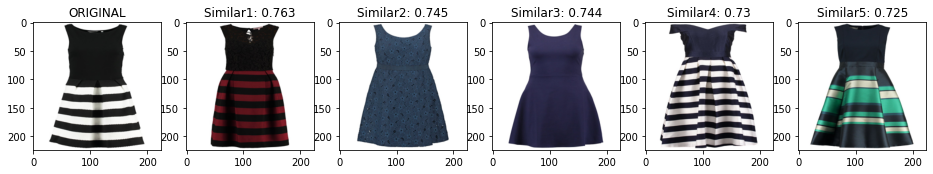

In [ ]:
plt.figure(figsize=(16,8))
most_similar_products(7,5)
plt.show()

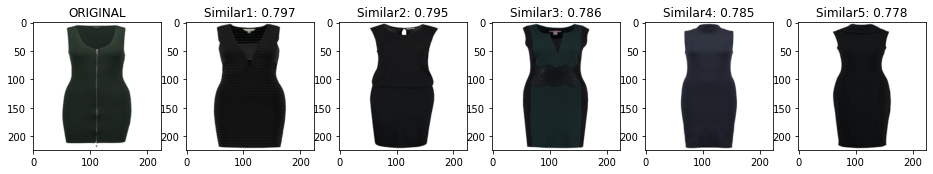

In [ ]:
plt.figure(figsize=(16,8))
most_similar_products(28,5)
plt.show()

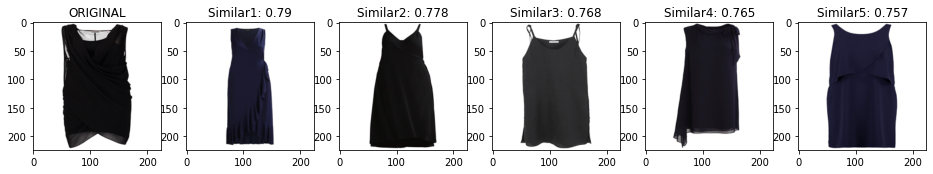

In [ ]:
plt.figure(figsize=(16,8))
most_similar_products(9,5)
plt.show()

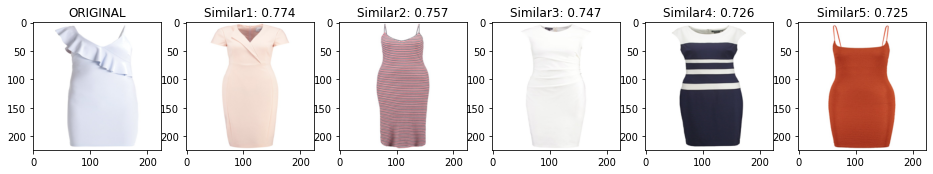

In [ ]:
plt.figure(figsize=(16,8))
most_similar_products(10,5)
plt.show()

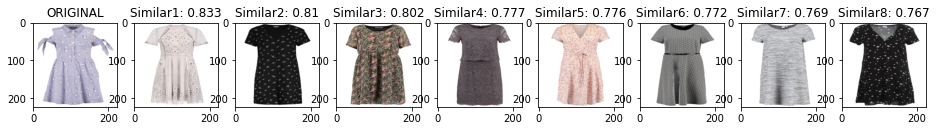

In [ ]:
plt.figure(figsize=(16,8))
most_similar_products(68,8)
plt.show()